In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
print("done!")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

done!


## first preprocess the data

In [2]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
import torch

# Strong augmentations for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Simple resize and normalization for validation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load your dataset (organized by class folders)
full_dataset = ImageFolder(root="/kaggle/input/mangoleaf-dataset/dataset")
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_indices, val_indices = random_split(range(len(full_dataset)), [train_size, val_size])

train_dataset = Subset(ImageFolder("/kaggle/input/mangoleaf-dataset/dataset", transform=train_transform), train_indices)
val_dataset = Subset(ImageFolder("/kaggle/input/mangoleaf-dataset/dataset", transform=val_transform), val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


## model preparation

In [3]:
!pip install timm

import timm
import torch.nn as nn

num_classes = 7  # update as needed
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, num_classes)


In [4]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)


In [5]:
from tqdm import tqdm
import copy

def evaluate_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return 100 * correct / total

def evaluate_loss(model, loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
    return val_loss / len(loader)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=5, save_path="vit_best.pth"):
    best_loss = float('inf')
    best_model = copy.deepcopy(model.state_dict())
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        val_loss = evaluate_loss(model, val_loader, criterion)
        val_acc = evaluate_accuracy(model, val_loader)
        print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            torch.save(best_model, save_path)
            print("Saved Best Model")
            no_improve = 0
        else:
            no_improve += 1
            print(f"No improvement for {no_improve} epoch(s)")

        if no_improve >= patience:
            print("Early Stopping")
            break

    model.load_state_dict(best_model)
    return model

# Train the model
model = train_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/20: 100%|██████████| 45/45 [04:44<00:00,  6.31s/it, loss=1.51]


Validation Loss: 1.7597 | Validation Accuracy: 35.93%
Saved Best Model


Epoch 2/20: 100%|██████████| 45/45 [03:45<00:00,  5.02s/it, loss=1.56]


Validation Loss: 1.5933 | Validation Accuracy: 36.49%
Saved Best Model


Epoch 3/20: 100%|██████████| 45/45 [03:43<00:00,  4.96s/it, loss=1.12] 


Validation Loss: 1.2606 | Validation Accuracy: 53.20%
Saved Best Model


Epoch 4/20: 100%|██████████| 45/45 [03:43<00:00,  4.97s/it, loss=0.867]


Validation Loss: 0.8711 | Validation Accuracy: 66.85%
Saved Best Model


Epoch 5/20: 100%|██████████| 45/45 [03:55<00:00,  5.23s/it, loss=1.3]  


Validation Loss: 0.9099 | Validation Accuracy: 64.07%
No improvement for 1 epoch(s)


Epoch 6/20: 100%|██████████| 45/45 [03:55<00:00,  5.23s/it, loss=0.656]


Validation Loss: 0.7506 | Validation Accuracy: 73.82%
Saved Best Model


Epoch 7/20: 100%|██████████| 45/45 [03:55<00:00,  5.24s/it, loss=0.585]


Validation Loss: 0.7888 | Validation Accuracy: 67.69%
No improvement for 1 epoch(s)


Epoch 8/20: 100%|██████████| 45/45 [03:53<00:00,  5.18s/it, loss=0.311]


Validation Loss: 0.4489 | Validation Accuracy: 83.29%
Saved Best Model


Epoch 9/20: 100%|██████████| 45/45 [03:53<00:00,  5.19s/it, loss=0.423]


Validation Loss: 0.6208 | Validation Accuracy: 77.72%
No improvement for 1 epoch(s)


Epoch 10/20: 100%|██████████| 45/45 [03:53<00:00,  5.20s/it, loss=0.791]


Validation Loss: 0.5643 | Validation Accuracy: 81.34%
No improvement for 2 epoch(s)


Epoch 11/20: 100%|██████████| 45/45 [03:53<00:00,  5.19s/it, loss=0.395]


Validation Loss: 0.4233 | Validation Accuracy: 84.68%
Saved Best Model


Epoch 12/20: 100%|██████████| 45/45 [03:54<00:00,  5.21s/it, loss=0.242]


Validation Loss: 0.5860 | Validation Accuracy: 79.94%
No improvement for 1 epoch(s)


Epoch 13/20: 100%|██████████| 45/45 [03:53<00:00,  5.19s/it, loss=0.666]


Validation Loss: 0.4449 | Validation Accuracy: 84.40%
No improvement for 2 epoch(s)


Epoch 14/20: 100%|██████████| 45/45 [03:55<00:00,  5.22s/it, loss=0.46] 


Validation Loss: 0.5615 | Validation Accuracy: 80.22%
No improvement for 3 epoch(s)


Epoch 15/20: 100%|██████████| 45/45 [03:57<00:00,  5.27s/it, loss=0.379]


Validation Loss: 0.4828 | Validation Accuracy: 83.01%
No improvement for 4 epoch(s)


Epoch 16/20: 100%|██████████| 45/45 [03:58<00:00,  5.29s/it, loss=0.308]


Validation Loss: 0.5096 | Validation Accuracy: 82.45%
No improvement for 5 epoch(s)
Early Stopping


/tmp/ipykernel_98/2985883200.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("vit_best.pth", map_location=torch.device('cpu')))


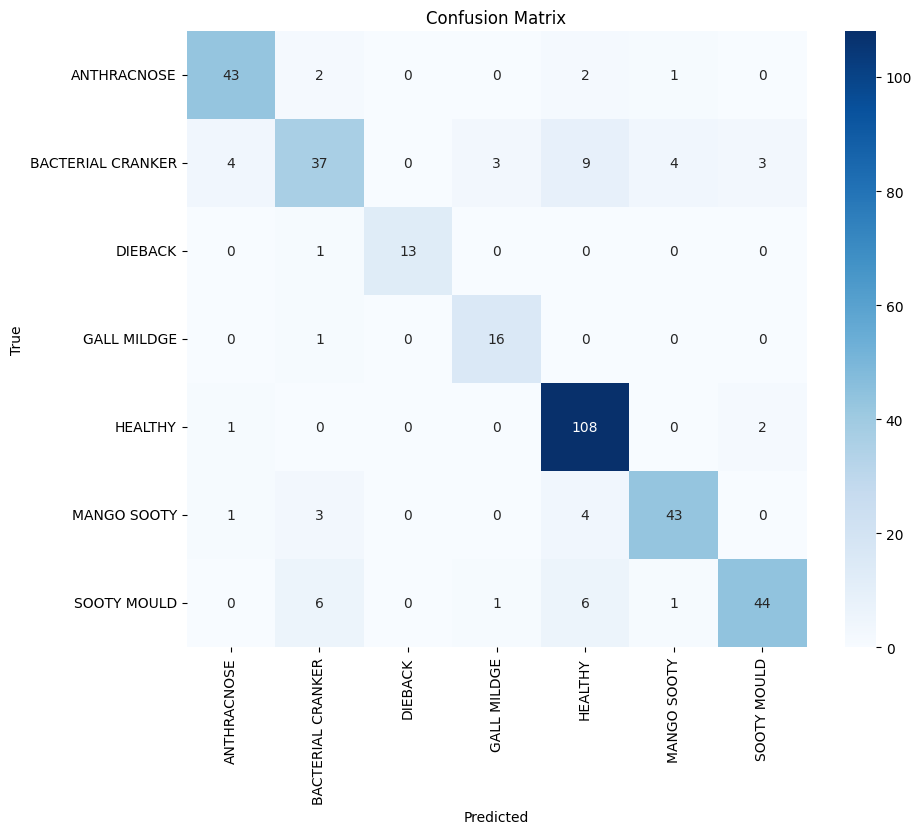

Classification Report:

                   precision    recall  f1-score   support

      ANTHRACNOSE       0.88      0.90      0.89        48
BACTERIAL CRANKER       0.74      0.62      0.67        60
          DIEBACK       1.00      0.93      0.96        14
      GALL MILDGE       0.80      0.94      0.86        17
          HEALTHY       0.84      0.97      0.90       111
      MANGO SOOTY       0.88      0.84      0.86        51
      SOOTY MOULD       0.90      0.76      0.82        58

         accuracy                           0.85       359
        macro avg       0.86      0.85      0.85       359
     weighted avg       0.85      0.85      0.84       359



In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.load_state_dict(torch.load("vit_best.pth", map_location=torch.device('cpu')))
model.eval()

class_names = full_dataset.classes
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


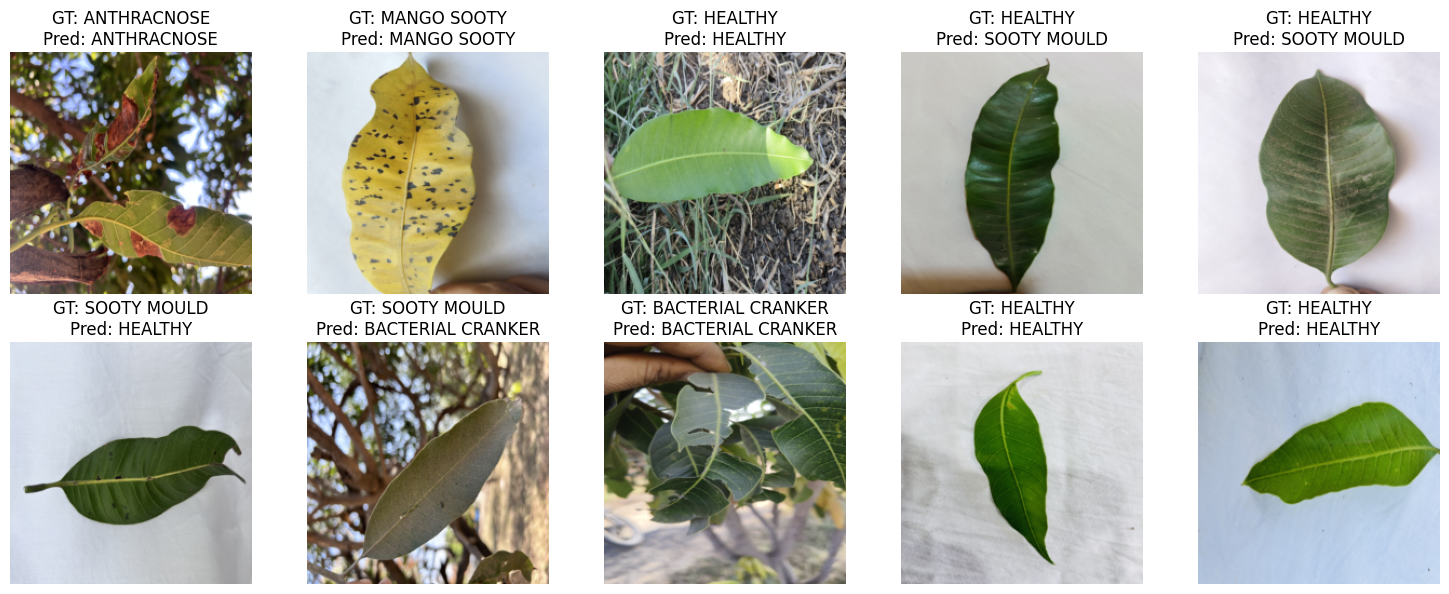

In [7]:
def unnormalize(img_tensor):
    return img_tensor * 0.5 + 0.5

images, labels = next(iter(val_loader))
images = images[:10]
labels = labels[:10]

model.eval()
with torch.no_grad():
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    img = unnormalize(images[i]).permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(f"GT: {class_names[labels[i]]}\nPred: {class_names[preds[i].cpu()]}")
    ax.axis("off")
plt.tight_layout()
plt.show()


torch.Size([1, 197, 768])
Attention map shape: (1, 197, 768)


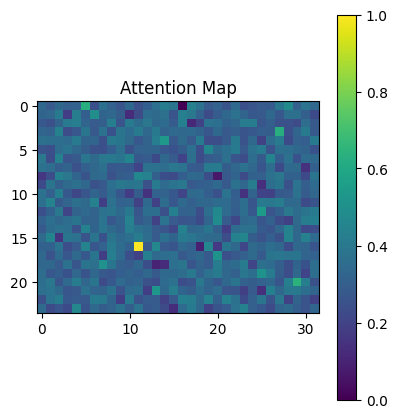

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import timm
from PIL import Image

# Function to register hook for attention weights
def register_attention_hook(model, layer_idx):
    attention_maps = []

    def hook_fn(module, input, output):
        # Check the shape of the output
        print(output.shape)  # This will help you understand the structure of the output
        if isinstance(output, tuple):
            attention_maps.append(output[0])  # Assuming the second element is the attention map
        else:
            attention_maps.append(output)  # If it's a single tensor, capture it

    # Register hook to get attention weights from the specified layer
    hook = model.blocks[layer_idx].attn.register_forward_hook(hook_fn)
    return hook, attention_maps

# Load pre-trained model and set it to evaluation mode
model = timm.create_model('vit_base_patch16_224', pretrained=True).to(device)
model.eval()

# Choose a correct image from the validation set
# Assuming val_loader is already defined
image, label = next(iter(val_loader))  # Take the first image from the validation set (you can modify this to select a specific one)
image = image[0].unsqueeze(0).to(device)  # Select the first image and add batch dimension

# Register the hook for layer 5 (you can choose any other layer too)
hook, attention_maps = register_attention_hook(model, layer_idx=5)

# Run inference on the image
with torch.no_grad():
    output = model(image)
    _, preds = torch.max(output, 1)

# Check if the hook has captured the attention map
if len(attention_maps) == 0:
    print("No attention map was captured. Check the hook registration.")
else:
    # The image was correctly classified, now extract the attention map from the hook
    attention_map = attention_maps[0].cpu().numpy()

    # Print attention map shape for debugging
    print(f"Attention map shape: {attention_map.shape}")

    # Normalize attention map for visualization (optional, depending on layer scale)
    attention_map = np.mean(attention_map, axis=1)  # We take the mean over the heads
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    # Assuming the attention map should be a square, and you know the height/width (e.g., 28x28)
    attention_map = attention_map.reshape((24, 32))   # Adjust to the correct shape

    # # Now you can plot the attention map
    # plt.imshow(attention_map, cmap='viridis')
    # plt.colorbar()
    # plt.title(f'Attention Map')
    # plt.show()

    # Optionally, visualize the image alongside the attention map for comparison
    image_to_show = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.imshow(image_to_show)
    # plt.title(f'Original Image - Class: {class_names[preds[0]]}')
    plt.subplot(1, 2, 2)
    plt.imshow(attention_map, cmap='viridis')
    plt.title('Attention Map')
    plt.colorbar()
    plt.show()


tensor([990], device='cuda:0')
